Compute the DMM and PA coupling coefficients in the Mediterranean region using the outputs of the HighResMIP set of numerical experiments. In this notebook a single numerical experiment is analysed.

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import xarray as xr
import pandas as pd
import glob
import geometry as gm # grad_sphere, div_sphere, nan_gaussian_filter
import distributions as dstr

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def nonlinear_metrics(x,y,n):
    """
    Compute the linear regression line for the central 90% of points of the distribution.
    With this, compute the mean signed difference between the y and the linear fit, to measure the nonlinearity.
    x and y are the variables of interest [S.I. units] and n is the number of points for each value of x.
    The ratio of the areas under the linear fit and the experimental points are computed.
    """
    from scipy import stats

    # Define the 5th and 95th percentiles of x, named x5 and x95, expoiting the information in n.
    ntot = np.sum(n)
    cdf = np.cumsum(n)/ntot
    i5 = np.argmin(np.abs(cdf-0.05))
    i95 = np.argmin(np.abs(cdf-0.95))
    x5 = x[i5]
    x95 = x[i95]

    # Perform the linear regression over this subset of points.
    sub_x = x[(x>=x5)&(x<=x95)]
    sub_y = y[(x>=x5)&(x<=x95)]
    sub_lsq_res = stats.linregress(sub_x, sub_y)
    sub_slope = sub_lsq_res[0]
    sub_intercept = sub_lsq_res[1]
    sub_y_fit = sub_slope*x+sub_intercept
    sub_slope_p = sub_lsq_res[3]

    return sub_slope, sub_intercept, x5, x95, sub_slope_p

In [6]:
# Define the experiment
exp_name = 'ECMWF-IFS-HR'
path2data = '/Users/alokkumarmishra/data_highresmip/Data/PAMMM/' + exp_name +'/'

In [7]:
# Select here the fields to be analysed, according to the selected mechanism.
mech = 'DMM' # 'DMM', 'PA'
if mech=='DMM':
    str_a = 'dsst_dr' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
    str_b = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
    alpha_units = 'm s$^{-1}$ K$^{-1}$' # 'm s$^{-1}$ K$^{-1}$' or 'm$^2$ s$^{-1}$ K$^{-1}$'
elif mech=='PA':
    str_a = 'd2sst_ds2' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
    str_b = 'ds_dot_prime_ds' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
    alpha_units = 'm$^2$ s$^{-1}$ K$^{-1}$' # 'm s$^{-1}$ K$^{-1}$' or 'm$^2$ s$^{-1}$ K$^{-1}$'

# Set the standard deviation of the Gaussian filter, to be used for the background fields.
sigma = 10 # with dx=25 km this corresponds to 250 km.

/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/1725147483.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(llon,llat,seamask)


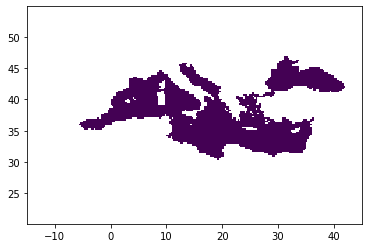

In [8]:
# Based on the experiment define the file names for u, v and SST.
if exp_name=='ECMWF-IFS-HR':
    u_file = 'uas_ECMWF-IFS-HR_sep2014.nc' # Is the file naming standardized?
    v_file = 'vas_ECMWF-IFS-HR_sep2014.nc'    
    sst_file = 'SST_ECMWF-IFS-HR_sep2014.nc'
    u_name = 'uas' # Are the variables saved with the same name?
    v_name = 'vas'
    sst_name = 'tos'
    
ds_sst = xr.open_dataset(path2data+sst_file)

lon = ds_sst.lon.values
lat = ds_sst.lat.values
llon,llat = np.meshgrid(lon,lat)

# Read the fist instant only to define the seamask, valid over the Med only.
# Some grid points (defined by maxshift) are removed from the coastlines. # Avoid this for the moment.
tos = ds_sst[sst_name][0].values 

seamask = tos.copy()
seamask[llat<30] = np.nan
seamask[llon<-6.2] = np.nan
seamask[llat>50] = np.nan
seamask[llat>35.5+(50-35.5)/(10+6.2)*(llon+6.2)] = np.nan
seamask /= seamask

plt.figure()
plt.pcolormesh(llon,llat,seamask)

#maxshift = 1 # dx=??? km
#for ss in range(maxshift):
#    seamask_sw = np.roll(seamask,-(ss+1),axis=[0,1])
#    seamask_ne = np.roll(seamask,ss+1,axis=[0,1])
#    seamask_nw = np.roll(seamask,[ss+1,-(ss+1)],axis=[0,1])
#    seamask_se = np.roll(seamask,[-(ss+1),ss+1],axis=[0,1])
#    seamask = seamask_sw*seamask_ne*seamask_nw*seamask_se
#seamask /= seamask
#plt.figure()
#plt.pcolormesh(llon,llat,seamask)

In [46]:
# Loop on time, the frequency of analysis is daily.
# This has to be setup according to the file structure.
a = []
b = []
tt = 0


# Compute the metrics of interest for the first instant.

ds_u = xr.open_dataset(path2data+u_file)
ds_v = xr.open_dataset(path2data+v_file)
ds_sst = xr.open_dataset(path2data+sst_file)

# Get the anomalies with respect to the background wind field
# Get the anomalies with respect to the background wind field
u110 = ds_u[u_name].values
v110 = ds_v[v_name].values
ws1pd = np.sqrt(u110**2+v110**2)

sst = ds_sst[sst_name].values

ap=np.zeros([140,241])
ap=ap*np.nan
bp=np.zeros([140,241])
bp=bp*np.nan
#all_arr=np.zeros([140,241])
#all_arr=all_arr*np.nan
all_a_prime=[]
all_b_prime=[]
for i in range(0,29):
    sst1=sst[i, :, :]
    u10=u110[i, :, :]
    v10=v110[i, :, :]
    wspd=ws1pd[i, :, :]
    dsst_dx, dsst_dy = gm.grad_sphere(sst1*seamask,llon,llat)
    # Get the background wind field.
    smooth_u = gm.nan_gaussian_filter(u10*seamask,sigma)
    smooth_v = gm.nan_gaussian_filter(v10*seamask,sigma)
    smooth_ws = np.sqrt(smooth_u**2+smooth_v**2)
    ##
    cosphi = smooth_u/smooth_ws
    sinphi = smooth_v/smooth_ws
    u_prime = u10-smooth_u
    v_prime = v10-smooth_v


    if str_a=='gamma':
        a_prime = u10*dsst_dx + v10*dsst_dy
        x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
    elif str_a=='dsst_dr':
        a_prime = dsst_dx*cosphi + dsst_dy*sinphi
        x_string = 'dSST/dr [K/m]'; vmin_a=-5e-5; vmax_a=5e-5
    elif str_a=='lapl_sst':
        a_prime = gm.div_sphere(dsst_dx,dsst_dy,llon,llat)
        x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
    elif str_a=='d2sst_ds2':
        dsst_ds = -dsst_dx*sinphi + dsst_dy*cosphi
        ddsst_ds_dx, ddsst_ds_dy = gm.grad_sphere(dsst_ds,llon,llat)
        a_prime = -ddsst_ds_dx*sinphi + ddsst_ds_dy*cosphi
        x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-5e-9; vmax_a=5e-9

    if str_b=='wind_div':
        b_prime = gm.div_sphere(u10,v10,llon,llat)
        y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
    elif str_b=='dr_dot_prime_dr':
        r_dot_prime = u_prime*cosphi + v_prime*sinphi
        dr_dot_prime_dx, dr_dot_prime_dy = gm.grad_sphere(r_dot_prime,llon,llat)
        b_prime = dr_dot_prime_dx*cosphi + dr_dot_prime_dy*sinphi 
        y_string = 'dr dot prime/dr [1/s]'; vmin_b=-1e-4; vmax_b=1e-4#vmin_b=-2.2e-4; vmax_b=2.2e-4
    elif str_b=='ds_dot_prime_ds':
        s_dot_prime = -u_prime*sinphi + v_prime*cosphi
        ds_dot_prime_dx, ds_dot_prime_dy = gm.grad_sphere(s_dot_prime,llon,llat)
        b_prime = -ds_dot_prime_dx*sinphi + ds_dot_prime_dy*cosphi
        y_string = 'ds dot prime/ds [1/s]'; vmin_b=-1e-4; vmax_b=1e-4#vmin_b=-2.2e-5; vmax_b=2.2e-5
        
    all_a_prime.append(a_prime)
    all_b_prime.append(b_prime)              
print('Done')
a_prime_mean=np.nanmean(all_a_prime,axis=0)
b_prime_mean=np.nanmean(all_b_prime,axis=0)        

# Concatenate the variables of interest.
a_to_be_concat = a_prime_mean[(~np.isnan(a_prime_mean))&(~np.isnan(b_prime_mean))]
b_to_be_concat = b_prime_mean[(~np.isnan(a_prime_mean))&(~np.isnan(b_prime_mean))]

a = np.concatenate((a,a_to_be_concat))
b = np.concatenate((b,b_to_be_concat))


/Users/alokkumarmishra/PycharmProjects/Medicane/PADMM/geometry.py:77: RuntimeWarning: divide by zero encountered in divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
/Users/alokkumarmishra/PycharmProjects/Medicane/PADMM/geometry.py:77: RuntimeWarning: invalid value encountered in divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/3646564502.py:41: RuntimeWarning: invalid value encountered in divide
  cosphi = smooth_u/smooth_ws
/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/3646564502.py:42: RuntimeWarning: invalid value encountered in divide
  sinphi = smooth_v/smooth_ws


Done


/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/3646564502.py:79: RuntimeWarning: Mean of empty slice
  a_prime_mean=np.nanmean(all_a_prime,axis=0)
/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/3646564502.py:80: RuntimeWarning: Mean of empty slice
  b_prime_mean=np.nanmean(all_b_prime,axis=0)


/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/3081079679.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = plt.pcolormesh(llon,llat,a_prime_mean,vmin=-8e-5,vmax=8e-5,cmap='seismic')
/var/folders/71/fz0fvvsx1pl0r67fcqt_n_1w0000gn/T/ipykernel_8408/3081079679.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = plt.pcolormesh(llon,llat,b_prime_mean,vmin=-8e-5,vmax=8e-5,cmap='seismic')


(-8.0, 43.0)

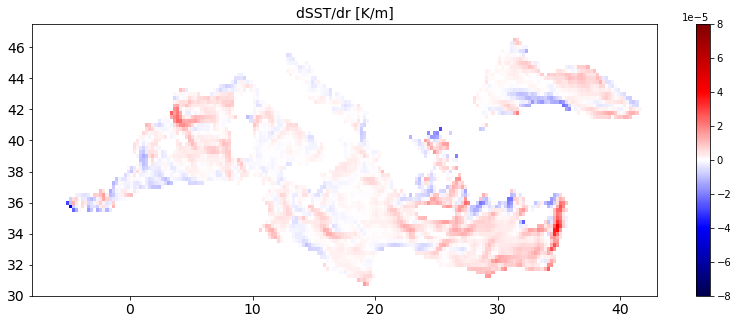

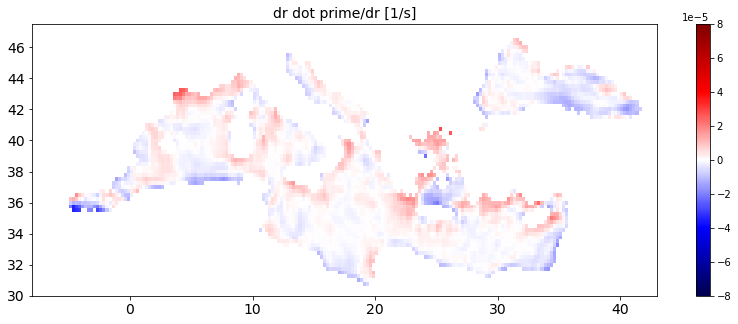

In [80]:
# Examples of maps

plt.figure(figsize=(14,5))
pc = plt.pcolormesh(llon,llat,a_prime_mean,vmin=-8e-5,vmax=8e-5,cmap='seismic')
plt.colorbar(pc)
plt.title(x_string,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.ylim([30,47.5])
plt.xlim([-8,43])

plt.figure(figsize=(14,5))
pc = plt.pcolormesh(llon,llat,b_prime_mean,vmin=-8e-5,vmax=8e-5,cmap='seismic')
plt.colorbar(pc)
plt.title(y_string,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.ylim([30,47.5])
plt.xlim([-8,43])

/Users/alokkumarmishra/PycharmProjects/Medicane/PADMM/distributions.py:82: RuntimeWarning: Mean of empty slice
  distribution_fb[qq] = np.nanmean(variable[(control>=lower)&(control<upper)])
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alokkumarmishra/PycharmProjects/Medicane/PADMM/distributions.py:84: RuntimeWarning: Mean of empty slice
  distribution_control_fb[qq] = np.nanmean(control[(control>=lower)&(control<upper)])


ValueError: operands could not be broadcast together with shapes (17,) (20,) 

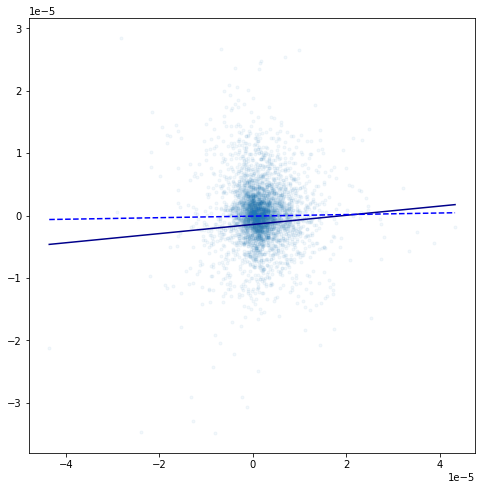

In [64]:
# Plot the distributions.
perc_step = 5

a[np.isinf(a)] = np.nan
b[np.isinf(b)] = np.nan

plt.figure(figsize=(8,8))
if mech=='DMM':
    thA = 2e-5
elif mech=='PA':
    thA = 2e-9
        
slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope, number_of_points_fb = dstr.metrics_fixed_bin_distribution(a,b,perc_step)        
sub_slope, sub_intercept, x5, x95, sub_slope_p = nonlinear_metrics(distribution_control_fb,distribution_fb,number_of_points_fb)

#plt.scatter(a[(a>thA)|(a<-thA)],b[(a>thA)|(a<-thA)],alpha=0.1,marker='.')
plt.scatter(a.flatten(),b.flatten(),alpha=0.05,marker='.')
ics = np.array([np.min(a),np.max(a)])
ipsilon = slope*ics + intercept
plt.plot(ics, ipsilon, 'darkblue')
plt.plot(ics, ics*sub_slope+sub_intercept,'--', color='blue')
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb/np.sqrt(number_of_points_fb),fmt='v',color='darkblue')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.ylim([-5e-4,5e-4])
#plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope), fontsize=16)
plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope) +
          '\nslope_sub = '+ "{:4.3f}".format(sub_slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(sub_slope_p), fontsize=16)


plt.figure(figsize=(8,8))
plt.plot(ics, ipsilon, 'darkblue')
plt.plot(ics, ics*sub_slope+sub_intercept,'--', color='blue')
plt.plot(distribution_control_fb,distribution_fb,'v',color='darkblue')
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb/np.sqrt(number_of_points_fb),fmt='v',color='darkblue')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope) +
          '\nslope_sub = '+ "{:4.3f}".format(sub_slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(sub_slope_p), fontsize=16)


#figure_name = 'scatter_plot_' + str_a + '_' + str_b + '_'+exp+ '.png'
#plt.savefig('./figures/'+figure_name,bbox_inches='tight')

In [67]:
distribution_control_fb.shape
distribution_fb.shape
std_distribution_fb.shape
(np.sqrt(number_of_points_fb)).shape
a_prime_mean.shape
b_to_be_concat.shape
std_distribution_fb.shape

(17,)